import required packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tensorflow.keras.datasets import fashion_mnist

In [ ]:
# Load Fashion MNIST
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data() # returns 2 tuples - training images and their labels, test images and their labels

In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
y_train.shape

(60000,)

Flatten the 2D image arrays into 1D vectors and normalize pixel values to prepare the data for input into machine learning models.

In [ ]:
X_train_flat = X_train.reshape(-1, 28*28).astype("float32") / 255.
X_test_flat = X_test.reshape(-1, 28*28).astype("float32") / 255.

In [ ]:
X_train_flat.shape

(60000, 784)

In [ ]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
 "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Displaying a Grid of Fashion MNIST Images with Class Labels

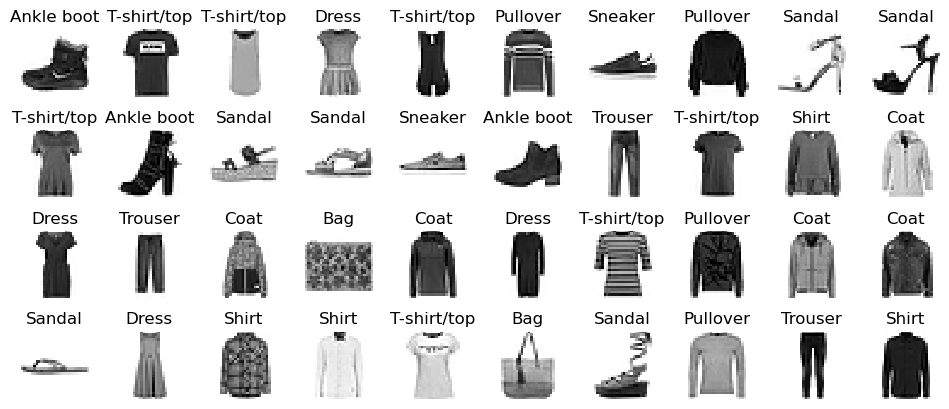

In [ ]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
         index = n_cols * row + col
         plt.subplot(n_rows, n_cols, index + 1)
         plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
         plt.axis('off')
         plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()


Clusters the training data into k clusters using the K-Means algorithm.



In [ ]:
def cluster_data(X_train_flat, k):
    # Cluster into k clusters using KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    X_train_dist = kmeans.fit_transform(X_train_flat)

    return kmeans, X_train_dist

Selects one representative image for each cluster — specifically, the image closest to each cluster center.



In [ ]:
def identify_representative_images(X_train_flat, X_train_dist, kmeans):
    # Identify 1 representative image per cluster
    rep_idx = np.argmin(X_train_dist, axis=0)  # closest points to the centroid
    X_reps = X_train_flat[rep_idx]
    y_reps = y_train[rep_idx]

    return X_reps, y_reps

To visualize one representative image per cluster, helping to interpret and manually label what each cluster represents.



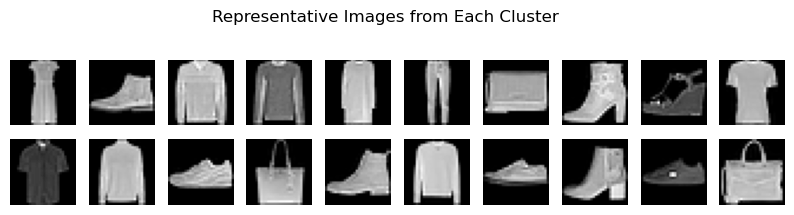

In [ ]:
# Visualize representative images (what you'd label manually)
kmeans,X_train_dist=cluster_data(X_train_flat,20)
X_reps,y_reps=identify_representative_images(X_train_flat,X_train_dist,kmeans)
plt.figure(figsize=(10, 5))
for i, img in enumerate(X_reps):
    plt.subplot(5, 10, i+1)
    plt.imshow(img.reshape(28, 28), cmap='gray')
    plt.axis("off")
plt.suptitle("Representative Images from Each Cluster")
plt.show()




Train a simple Logistic Regression model using only the representative samples from each cluster instead of the full dataset.



In [ ]:
from sklearn.linear_model import LogisticRegression

def train_on_representatives(X_train_flat,k):
    kmeans,X_train_dist=cluster_data(X_train_flat,k)
    X_reps,y_reps=identify_representative_images(X_train_flat,X_train_dist,kmeans)

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_reps, y_reps)

    return clf


Propagate labels to all data points based on their assigned clusters and train a Logistic Regression model on the entire dataset with the propagated labels.

In [ ]:
from sklearn.linear_model import LogisticRegression

def propagate_labels_and_train(X_train_flat, k, kmeans, y_reps):
    """
    Args:
    X_train_flat (array): The flattened training data.
    k (int): The number of clusters.
    kmeans (KMeans): The fitted KMeans object.
    y_reps (array): The representative labels corresponding to each cluster.

    Returns:
    clf_full (LogisticRegression): The trained Logistic Regression model.
    """
    # Initialize an empty array for propagated labels
    y_train_prop = np.empty(len(X_train_flat), dtype=np.int32)

    # Propagate the labels from the representative images to the rest of the points in the cluster
    for i in range(k):
        y_train_prop[kmeans.labels_ == i] = y_reps[i]

    # Train the Logistic Regression model using the entire dataset with the propagated labels
    clf_full = LogisticRegression(max_iter=1000)
    clf_full.fit(X_train_flat, y_train_prop)

    return clf_full,y_train_prop


Selects the closest points to their centroids (top 20%) from each cluster and trains a Logistic Regression model on this subset of data.

In [ ]:
from sklearn.linear_model import LogisticRegression
import numpy as np

def select_closest_points_and_train(X_train_flat, k, kmeans, X_train_dist, y_train_prop):
    """
    Args:
    X_train_flat (array): The flattened training data.
    k (int): The number of clusters.
    kmeans (KMeans): The fitted KMeans object.
    X_train_dist (array): The pairwise distance matrix from KMeans.
    y_train_prop (array): The propagated labels for the training data.

    Returns:
    clf_partial (LogisticRegression): The trained Logistic Regression model on the selected subset of data.
    """
    # Initialize a mask to filter the closest points
    mask = np.zeros(len(X_train_flat), dtype=bool)

    # Calculate the distance to each point's centroid
    dists = X_train_dist[np.arange(len(X_train_flat)), kmeans.labels_]

    # For each cluster, select the closest 20% of points to their respective centroids
    for i in range(k):
        cluster_idxs = np.where(kmeans.labels_ == i)[0]
        cluster_dists = dists[cluster_idxs]
        cutoff = np.percentile(cluster_dists, 20)  # 20th percentile distance to select closest points
        close_idxs = cluster_idxs[cluster_dists <= cutoff]
        mask[close_idxs] = True

    # Filter the data points and their labels based on the mask (top 20% closest points)
    X_selected = X_train_flat[mask]
    y_selected = y_train_prop[mask]

    # Train the Logistic Regression model using the selected points
    clf_partial = LogisticRegression(max_iter=1000)
    clf_partial.fit(X_selected, y_selected)

    return clf_partial


In [ ]:
# Assuming X_train_flat is your flattened training data and k is the number of clusters
clf = train_on_representatives(X_train_flat, k=20)

# You can now evaluate this model using your test set
accuracy = clf.score(X_test_flat, y_test)
print(f"Accuracy using only representative images: {accuracy}")


Accuracy using only representative images: 0.6083


In [ ]:
# Assuming X_train_flat is your flattened training data, k is the number of clusters,
# kmeans is your fitted KMeans model, and y_reps are the representative labels
kmeans,X_train_dist=cluster_data(X_train_flat,20)
clf_full,y_train_prop = propagate_labels_and_train(X_train_flat, k=20, kmeans=kmeans, y_reps=y_reps)

# You can now evaluate this model using your test set
accuracy_full = clf_full.score(X_test_flat, y_test)
print(f"Accuracy after full label propagation: {accuracy_full}")


Accuracy after full label propagation: 0.6075


In [ ]:
# Assuming you already have your trained KMeans model (kmeans), and X_train_dist (pairwise distances),
# and propagated labels (y_train_prop), you can use the function like this:
kmeans,X_train_dist=cluster_data(X_train_flat,20)
clf_full,y_train_prop = propagate_labels_and_train(X_train_flat, k=20, kmeans=kmeans, y_reps=y_reps)
clf_partial = select_closest_points_and_train(X_train_flat, k=20, kmeans=kmeans, X_train_dist=X_train_dist, y_train_prop=y_train_prop)

# Evaluate the model on the test set
accuracy_partial = clf_partial.score(X_test_flat, y_test)
print(f"Accuracy with partial propagation (top 20% closest points): {accuracy_partial}")


Accuracy with partial propagation (top 20% closest points): 0.6199


To evaluate the classification performance of a partially trained model using only the top 20% closest points (to centroids) with propagated labels across different cluster sizes k.



In [ ]:
import matplotlib.pyplot as plt

def run_partial_propagation_experiment(X_train_flat, X_test_flat, y_test, k_values):
    accuracies = []

    for k in k_values:
        print(f"\nRunning for k = {k}")

        # Step 1: KMeans clustering
        kmeans, X_train_dist = cluster_data(X_train_flat, k)  # Adjusted: you don't pass X_train_dist in

        # Step 2: Identify representatives
        X_reps, y_reps = identify_representative_images(X_train_flat,X_train_dist, kmeans)

        # Step 3: Propagate labels
        clf_full, y_train_prop = propagate_labels_and_train(X_train_flat, k=k, kmeans=kmeans, y_reps=y_reps)

        # Step 4: Select closest points and train partial model
        clf_partial = select_closest_points_and_train(
            X_train_flat, k=k, kmeans=kmeans, X_train_dist=X_train_dist, y_train_prop=y_train_prop
        )

        # Step 5: Evaluate
        accuracy = clf_partial.score(X_test_flat, y_test)
        print(f"Accuracy with partial propagation (top 20% closest points): {accuracy:.4f}")
        accuracies.append(accuracy)

    # Step 6: Plot results
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, accuracies, marker='o', color='purple')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Accuracy (Partial Propagation)')
    plt.title('Accuracy vs Number of Clusters')
    plt.grid(True)
    plt.show()



Running for k = 5
Accuracy with partial propagation (top 20% closest points): 0.3362

Running for k = 10
Accuracy with partial propagation (top 20% closest points): 0.5054

Running for k = 15
Accuracy with partial propagation (top 20% closest points): 0.5836

Running for k = 20
Accuracy with partial propagation (top 20% closest points): 0.6199

Running for k = 25
Accuracy with partial propagation (top 20% closest points): 0.6090

Running for k = 30
Accuracy with partial propagation (top 20% closest points): 0.6022

Running for k = 35
Accuracy with partial propagation (top 20% closest points): 0.5784

Running for k = 40
Accuracy with partial propagation (top 20% closest points): 0.5933

Running for k = 45
Accuracy with partial propagation (top 20% closest points): 0.6020

Running for k = 50
Accuracy with partial propagation (top 20% closest points): 0.6473

Running for k = 55
Accuracy with partial propagation (top 20% closest points): 0.6765

Running for k = 60
Accuracy with partial pr

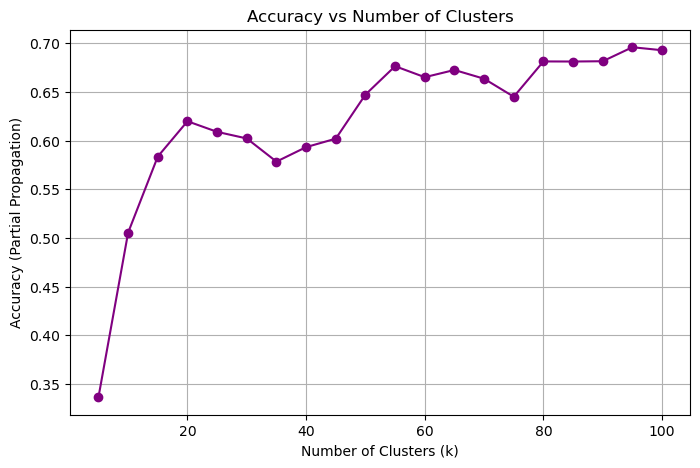

In [ ]:
k_values = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
run_partial_propagation_experiment(X_train_flat, X_test_flat, y_test, k_values)


MLP model - Defines and compiles a fully connected feedforward neural network to classify images from the Fashion MNIST dataset.



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def create_model(input_shape=(784,)):
    model = Sequential([
        Dense(256, activation='relu', input_shape=input_shape),  # Input shape is flattened image size
        Dropout(0.3),  # Helps prevent overfitting
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(10, activation='softmax')  # 10 classes for Fashion MNIST
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
model = create_model(input_shape=(784,))

D:\soft\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Setting up the model to learn using Adam, optimize for cross-entropy loss, and report accuracy as a performance metric during training and evaluation.



In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import numpy as np
from sklearn.cluster import KMeans

def select_closest_points_by_k_MLP(X_train_flat, k, kmeans, X_train_dist, y_train_prop):
    """
    Selects the closest 20% of points to their respective centroids for each of the k clusters.

    Args:
    X_train_flat (array): The flattened training data.
    k (int): The number of clusters.
    kmeans (KMeans): The fitted KMeans object.
    X_train_dist (array): The pairwise distance matrix from KMeans.
    y_train_prop (array): The propagated labels for the training data.

    Returns:
    X_selected (array): The data points closest to their centroids.
    y_selected (array): The labels for the selected data points.
    """
    # Initialize a mask to filter the closest points
    mask = np.zeros(len(X_train_flat), dtype=bool)

    # Calculate the distance to each point's centroid
    dists = X_train_dist[np.arange(len(X_train_flat)), kmeans.labels_]

    # For each cluster, select the closest 20% of points to their respective centroids
    for i in range(k):
        cluster_idxs = np.where(kmeans.labels_ == i)[0]
        cluster_dists = dists[cluster_idxs]
        cutoff = np.percentile(cluster_dists, 20)  # 20th percentile distance to select closest points
        close_idxs = cluster_idxs[cluster_dists <= cutoff]
        mask[close_idxs] = True

    # Filter the data points and their labels based on the mask (top 20% closest points)
    X_selected = X_train_flat[mask]
    y_selected = y_train_prop[mask]

    return X_selected, y_selected


In [ ]:
from tensorflow.keras.utils import to_categorical
k=20
kmeans,X_train_dist=cluster_data(X_train_flat,k)
X_selected, y_selected=select_closest_points_by_k_MLP(X_train_flat, k, kmeans, X_train_dist, y_train_prop)
# Convert the labels to categorical (one-hot encoding)
y_selected_cat = to_categorical(y_selected, num_classes=10)


In [ ]:
model.fit(
    X_selected,
    y_selected_cat,
    epochs=10,         # Number of training iterations over the entire dataset
    batch_size=32,     # Number of samples per gradient update
    verbose=1
)


Epoch 1/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8153 - loss: 0.5187
Epoch 2/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9665 - loss: 0.0968
Epoch 3/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9729 - loss: 0.0773
Epoch 4/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9758 - loss: 0.0617
Epoch 5/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9802 - loss: 0.0570
Epoch 6/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9807 - loss: 0.0527
Epoch 7/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9822 - loss: 0.0507
Epoch 8/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9861 - loss: 0.0426
Epoch 9/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9856 - loss: 0.0432
Epoch 10/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9864 - loss: 0.0359


In [ ]:
from tensorflow import keras

test_loss, test_acc = model.evaluate(X_test_flat, keras.utils.to_categorical(y_test, num_classes=10))
print(f"Test accuracy: {test_acc:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6343 - loss: 6.5369
Test accuracy: 0.6398


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import to_categorical

def run_partial_propagation_experiment_MLP(X_train_flat, X_test_flat, y_test, k_values, model):
    accuracies = []

    for k in k_values:
        print(f"\nRunning for k = {k}")

        # Step 1: KMeans clustering
        kmeans, X_train_dist = cluster_data(X_train_flat, k)

        # Step 2: Identify representatives
        X_reps, y_reps = identify_representative_images(X_train_flat, X_train_dist, kmeans)

        # Step 3: Propagate labels
        # Initialize an empty array for propagated labels
        y_train_prop = np.empty(len(X_train_flat), dtype=np.int32)

        # Propagate the labels from the representative images to the rest of the points in the cluster
        for i in range(k):
            y_train_prop[kmeans.labels_ == i] = y_reps[i]

        # Step 4: Select the closest points to the centroids
        X_selected, y_selected = select_closest_points_by_k_MLP(X_train_flat, k, kmeans, X_train_dist, y_train_prop)

        # Convert the labels to categorical (one-hot encoding)
        y_selected_cat = to_categorical(y_selected, num_classes=10)

        # Train the model
        model.fit(
                X_selected,
                y_selected_cat,
                epochs=10,
                batch_size=32,
                verbose=1
        )

        # Step 5: Evaluate
        test_loss, test_acc = model.evaluate(X_test_flat, keras.utils.to_categorical(y_test, num_classes=10))
        print(f"Test accuracy for k={k}: {test_acc:.4f}")

        accuracies.append(test_acc)  # Append the accuracy of the model

    # Step 6: Plot results
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, accuracies, marker='o', color='purple')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Accuracy (Partial Propagation)')
    plt.title('Accuracy vs Number of Clusters')
    plt.grid(True)
    plt.show()


D:\soft\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Running for k = 5
Epoch 1/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8771 - loss: 0.3227
Epoch 2/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9740 - loss: 0.0710
Epoch 3/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9802 - loss: 0.0527
Epoch 4/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9841 - loss: 0.0447
Epoch 5/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9880 - loss: 0.0314
Epoch 6/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9890 - loss: 0.0336
Epoch 7/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9906 - loss: 0.0255
Epoch 8/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9902 - loss: 0.0286
Epoch 9/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9940 - loss: 0.0172
Epoch 10/10
376/376 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9908 - loss: 0.0234
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3245 - loss: 15.3049
Test accuracy for k=5: 0.3280

Running for k

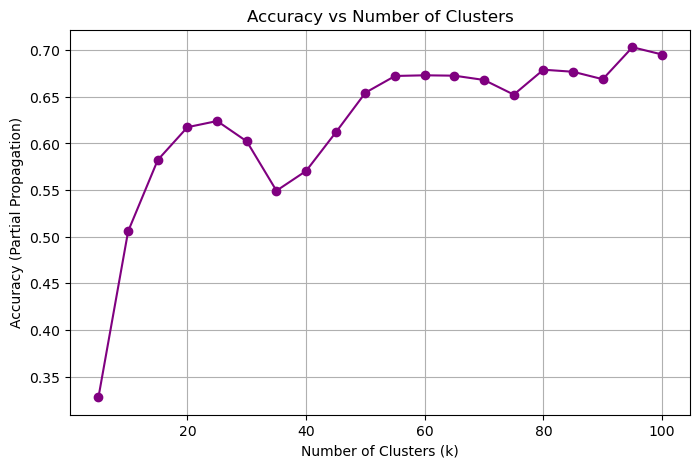

In [ ]:
# Define model and pass it to the experiment function
model1 = create_model(input_shape=(X_train_flat.shape[1],))
run_partial_propagation_experiment_MLP(X_train_flat, X_test_flat, y_test, k_values=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95 ,100], model=model1)
